<a href="https://colab.research.google.com/github/Anantha-Rao12/NMR-ML4SCI-GSOC21/blob/main/June15_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Principal Component Analysis
from sklearn.decomposition import PCA

In [181]:
def load_data(path:str, as_df=True):
    """Given the path of the directory containing the data, 
    the respective mat_file and M_curves data is loaded"""
    mat_file = "echo_params.txt"
    M_file_r = "echos_r" # real part of echos
    M_file_i = "echos_i" # imaginary part of echos

    mat_info = np.loadtxt(os.path.join(path,mat_file));

    # M(t) curve for each simulation:
    M_r = np.loadtxt(os.path.join(path,M_file_r));
    M_i = np.loadtxt(os.path.join(path,M_file_i));
    print("Finished loading data into numpy array")
    return np.abs(M_r + 1j*M_i)

def load_params(path:str):
    """Given the directory path loads the input parameter files for the simualtions"""
    params = np.loadtxt(os.path.join(path,"echo_params.txt"))
    cols = 'αx αy αz ξ p Γ3 stencil_type s p d pulse90 pulse180'.split()
    print("Finsihed laoding parameters file")
    return pd.DataFrame(params,columns=cols)

def get_window(data:np.ndarray, center_ratio:float, width:float):
    """Returns a subset of the given array with only those datapoints between 
    [center - width , center + width] for all rows/examples"""
    start = int((center_ratio)*data.shape[1])
    return data[:,start-width:start+width], start

def standard_scale(data:np.ndarray):
    """Standardizing the given array with mean=0 and variance=1 column-wise"""
    mean,std = np.mean(data,axis=0), np.std(data,axis=0)
    return (data-mean)/std

def normalize(data:np.ndarray):
    """Normalizing the data so that all values are within the new range of 0 and 1"""
    return (data - np.min(data,axis=0))/(np.max(data,axis=0) - np.min(data,axis=0))

def pca2D(data:np.ndarray):
    """Returns a 2D PCA version of the given dataset. 
    The given dataset (input) should already be normalised. 
    Returns: 
        Dim-reduced 2D data, variance explained by the two dimensions"""
    pca2D = PCA(n_components=2)
    pca2D_data = pca2D.fit_transform(data)
    variance = pca2D.explained_variance_ratio_
    principal_data = pd.DataFrame(data = pca2D_data, columns = ['PC1', 'PC2'])
    return principal_data, variance

def pca3D(data:np.ndarray):
    """Returns a 3D PCA version of the given dataset. 
    The given dataset (input) should already be normalised. 
    Returns: 
        Dim-reduced 3D data, variance explained by the two dimensions"""
    pca2D = PCA(n_components=3)
    pca2D_data = pca2D.fit_transform(data)
    variance = pca2D.explained_variance_ratio_
    principal_data = pd.DataFrame(data = pca2D_data, columns = ['PC1', 'PC2','PC3'])
    return principal_data, variance

In [103]:
path = '/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-10_oscar_spinechosim_cuda/'

M = load_data(path,False)
M, center = get_window(M,2/3,200)

Finished loading data into numpy array


In [135]:
# Normalise the Data
norm_data = normalize(M) # normalizing the features

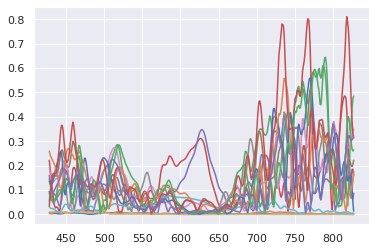

In [109]:
for i in range(15):
    plt.plot(range(center-200,center+200),norm_data[10*i,:])

In [110]:
# convert the normalized features into a tabular format
feat_cols = ['feature'+str(i) for i in range(norm_data.shape[1])]
normalised_data = pd.DataFrame(norm_data,columns=feat_cols)
normalised_data.tail()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,...,feature360,feature361,feature362,feature363,feature364,feature365,feature366,feature367,feature368,feature369,feature370,feature371,feature372,feature373,feature374,feature375,feature376,feature377,feature378,feature379,feature380,feature381,feature382,feature383,feature384,feature385,feature386,feature387,feature388,feature389,feature390,feature391,feature392,feature393,feature394,feature395,feature396,feature397,feature398,feature399
9995,0.170888,0.163347,0.161705,0.162604,0.161854,0.155653,0.143451,0.126714,0.108207,0.090967,0.077439,0.069551,0.068160,0.073434,0.085204,0.103157,0.127061,0.155736,0.185483,0.211588,0.230702,0.238574,0.234959,0.220511,0.197140,0.167978,0.138206,0.115461,0.108800,0.120682,0.141144,0.159760,0.162637,0.157452,0.147281,0.133935,0.119135,0.104264,0.091531,0.080764,...,0.292932,0.304879,0.316937,0.326709,0.332646,0.330133,0.300569,0.266554,0.232619,0.205111,0.189685,0.189181,0.198969,0.202038,0.194998,0.189503,0.185035,0.181536,0.178921,0.176921,0.175284,0.173841,0.172026,0.169085,0.164862,0.160618,0.159629,0.165802,0.181006,0.203471,0.215014,0.207664,0.196786,0.180386,0.162839,0.155191,0.156740,0.166210,0.186029,0.218715
9996,0.064970,0.054466,0.044645,0.035660,0.028453,0.022709,0.018490,0.015553,0.013852,0.013325,0.013608,0.014516,0.015861,0.018127,0.022020,0.027668,0.035002,0.043567,0.051987,0.058986,0.064653,0.066601,0.065131,0.060086,0.051762,0.040724,0.028350,0.016382,0.010794,0.017445,0.024672,0.027679,0.023825,0.015481,0.004745,0.009018,0.021103,0.031073,0.038488,0.041628,...,0.019822,0.017002,0.024963,0.037780,0.050737,0.061337,0.064817,0.064899,0.062749,0.059722,0.056797,0.054617,0.052727,0.048435,0.042814,0.039084,0.036935,0.036210,0.036877,0.038875,0.042029,0.045986,0.050354,0.054820,0.059249,0.063622,0.067959,0.072245,0.076346,0.079917,0.077708,0.069694,0.062635,0.055845,0.049860,0.046956,0.046260,0.046962,0.048951,0.051761
9997,0.017894,0.018499,0.020452,0.023366,0.027836,0.033533,0.040302,0.047134,0.053077,0.057500,0.059728,0.059813,0.058346,0.056805,0.058045,0.064357,0.074994,0.086782,0.096090,0.100449,0.100592,0.096148,0.089059,0.080907,0.073017,0.066184,0.061790,0.059959,0.060292,0.063552,0.069021,0.076361,0.080620,0.084698,0.088520,0.091306,0.092476,0.091314,0.088398,0.082183,...,0.029493,0.031109,0.030577,0.028061,0.024259,0.019584,0.014216,0.010415,0.008263,0.007742,0.008746,0.011757,0.016993,0.022879,0.028086,0.033480,0.038617,0.042960,0.045926,0.046894,0.045625,0.042369,0.037856,0.033236,0.029651,0.027803,0.027595,0.028169,0.028726,0.028811,0.026744,0.023880,0.023631,0.025544,0.027958,0.030263,0.031725,0.031918,0.030989,0.028815
9998,0.036372,0.033429,0.031050,0.028882,0.027526,0.026484,0.025785,0.025185,0.024644,0.024320,0.024352,0.025095,0.026473,0.028579,0.031558,0.035072,0.039023,0.043146,0.046587,0.048937,0.051035,0.051257,0.050353,0.048196,0.045058,0.041078,0.036855,0.032566,0.027856,0.023897,0.021324,0.020964,0.021976,0.024818,0.028841,0.033741,0.038795,0.042964,0.046400,0.047182,...,0.015776,0.015566,0.015099,0.014185,0.012809,0.010971,0.008746,0.007724,0.008142,0.009251,0.010281,0.010847,0.010618,0.009191,0.007226,0.005863,0.005415,0.005646,0.006087,0.006481,0.006989,0.007898,0.009239,0.010689,0.011876,0.012558,0.012647,0.012243,0.011587,0.010910,0.009907,0.008804,0.008249,0.007829,0.007452,0.007702,0.008721,0.010442,0.012776,0.015339
9999,0.023011,0.017436,0.012797,0.009504,0.008473,0.008606,0.009143,0.009422,0.009122,0.008130,0.006531,0.005253,0.005681,0.007745,0.009776,0.010265,0.008705,0.006417,0.008067,0.013633,0.020458,0.025104,0.027486,0.027217,0.024432,0.019455,0.013189,0

# Principal Component Analysis

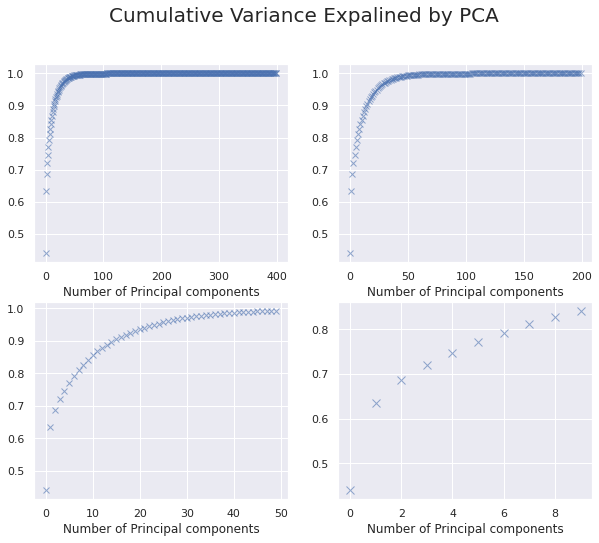

In [243]:
# Choosing the number of components
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
pca = PCA().fit(norm_data)

axes[0,0].plot(np.cumsum(pca.explained_variance_ratio_),'bx',alpha=0.6)
axes[0,1].plot(np.cumsum(pca.explained_variance_ratio_)[:200],'bx',alpha=0.6)
axes[1,0].plot(np.cumsum(pca.explained_variance_ratio_)[:50],'bx',alpha=0.6)
axes[1,1].plot(np.cumsum(pca.explained_variance_ratio_)[:10],'bx',markersize=8,alpha=0.6)

for _,ax in np.ndenumerate(axes):
    ax.set_xlabel('Number of Principal components')
plt.suptitle('Cumulative Variance Expalined by PCA',fontsize=20)
plt.show()

### Two dimensional PCA

In [167]:
principal_NMR_2d, NMR_explained_ratio_2d = pca2D(norm_data)

In [168]:
print('Explained variation per principal component: {}'.format(NMR_explained_ratio_2d))

Explained variation per principal component: [0.43971787 0.19508646]


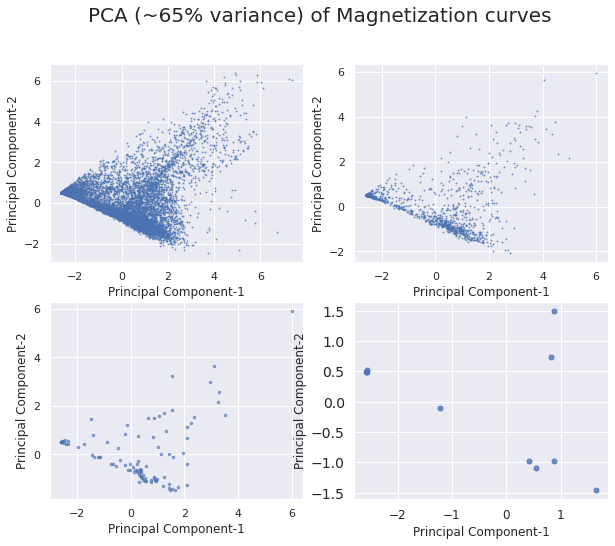

In [237]:
idx = lambda x : range(0,len(norm_data),x)
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.suptitle("PCA (~65% variance) of Magnetization curves",fontsize=20)

for _,ax in np.ndenumerate(axes):
    ax.set_xlabel('Principal Component-1')
    ax.set_ylabel('Principal Component-2')

axes[0,0].plot(principal_NMR_2d.PC1[idx(1)],principal_NMR_2d.PC2[idx(1)],'b.',markersize=2, alpha=0.6)
axes[0,1].plot(principal_NMR_2d.PC1[idx(10)],principal_NMR_2d.PC2[idx(10)],'b.',markersize=2, alpha=0.6)
axes[1,0].plot(principal_NMR_2d.PC1[idx(100)],principal_NMR_2d.PC2[idx(100)],'b.',markersize=5, alpha=0.6)
axes[1,1].plot(principal_NMR_2d.PC1[idx(1000)],principal_NMR_2d.PC2[idx(1000)],'b.',markersize=10, alpha=0.8)

plt.show()

### 3D PCA

In [182]:
principal_NMR_3d, NMR_explained_ratio_3d = pca3D(norm_data)
principal_NMR_3d.tail()

,PC1,PC2,PC3
9995,2.904552,1.392783,0.925198
9996,-1.856399,0.244764,0.112676
9997,-2.049967,0.294335,-0.124635
9998,-2.401113,0.419330,-0.041940
9999,-2.074063,0.963507,0.066797


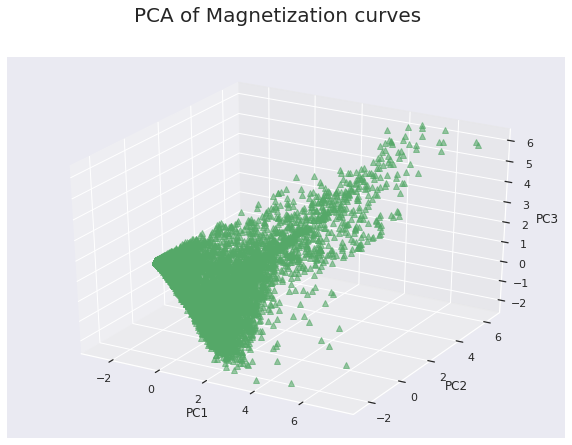

In [221]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.plot(principal_NMR_3d.PC1, principal_NMR_3d.PC2, principal_NMR_3d.PC2, 'g^',alpha=0.6)
ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
plt.suptitle("PCA of Magnetization curves",fontsize=20)

plt.show()

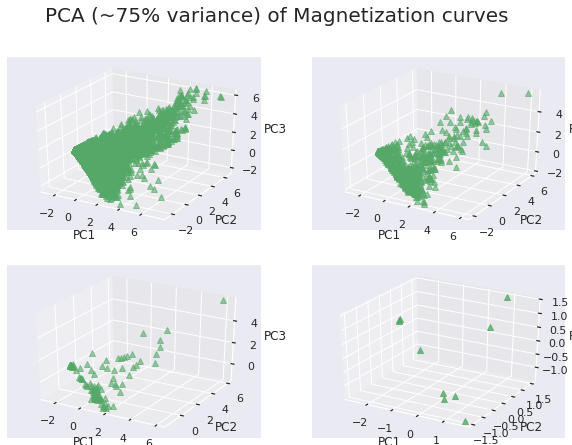

In [234]:
fig = plt.figure(figsize=(10, 7))
plt.suptitle("PCA (~75% variance) of Magnetization curves",fontsize=20)

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')

ax.plot3D(principal_NMR_3d.PC1[idx(1)], principal_NMR_3d.PC2[idx(1)], 
             principal_NMR_3d.PC2[idx(1)], 'g^',alpha=0.6)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')

ax.plot3D(principal_NMR_3d.PC1[idx(10)], principal_NMR_3d.PC2[idx(10)], 
             principal_NMR_3d.PC2[idx(10)], 'g^',alpha=0.6)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
ax.plot3D(principal_NMR_3d.PC1[idx(100)], principal_NMR_3d.PC2[idx(100)], 
             principal_NMR_3d.PC2[idx(100)], 'g^',alpha=0.6)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
ax.plot3D(principal_NMR_3d.PC1[idx(1000)], principal_NMR_3d.PC2[idx(1000)], 
             principal_NMR_3d.PC2[idx(1000)], 'g^',alpha=0.8)

plt.show()

# Conclusions

- We can see 3 distinct clusters in the PCA plot (both 2D, 3D). This reiterates the fact that the different kind of functional forms of the interaction between spins is of 3 kinds. Gaussian, Power-law and RKKY type. 

- We will now look at other embedding technqiues like t-SNE and UMAP